# Over Fitting demo

### use a sin-relationship to test the polynomial

In [2]:
import graphlab
import math
import random
import numpy
from matplotlib import pyplot as plt
%matplotlib inline

[INFO] 1452150889 : INFO:     (initialize_globals_from_environment:282): Setting configuration variable GRAPHLAB_FILEIO_ALTERNATIVE_SSL_CERT_FILE to /usr/local/lib/python2.7/dist-packages/certifi/cacert.pem
1452150889 : INFO:     (initialize_globals_from_environment:282): Setting configuration variable GRAPHLAB_FILEIO_ALTERNATIVE_SSL_CERT_DIR to 
This non-commercial license of GraphLab Create is assigned to 527536646@qq.com and will expire on October 23, 2016. For commercial licensing options, visit https://dato.com/buy/.

[INFO] Start server at: ipc:///tmp/graphlab_server-1728 - Server binary: /usr/local/lib/python2.7/dist-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1452150889.log
[INFO] GraphLab Server Version: 1.7.1


#### Create random values for x in interval [0,1)

In [3]:
random.seed(98103)
n = 30
x = graphlab.SArray([random.random() for i in range(n)]).sort()


#### build a sin()

In [4]:
y = x.apply(lambda x: math.sin(4*x))

#### add random noise in y

In [5]:
random.seed(1)
e = graphlab.SArray([random.gauss(0,1.0/3.0) for i in range(n)])
y = y + e

### Put data into SFrame

In [6]:
data = graphlab.SFrame({'X1':x, 'Y':y})
data


X1,Y
0.0395789449501,0.587050191026
0.0415680996791,0.648655851372
0.0724319480801,0.307803309485
0.150289044622,0.310748447417
0.161334144502,0.237409625496
0.191956312795,0.705017157224
0.232833917145,0.461716676992
0.259900980166,0.383260507851
0.380145814869,1.06517691429
0.432444723508,1.03184706949


### the plot function would apppear many times, put it in a function

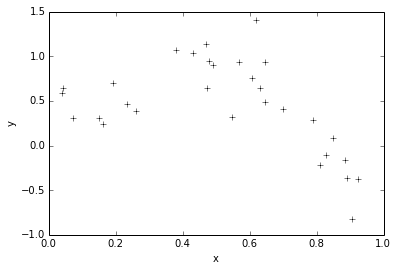

In [7]:
def plot_data(data):
    plt.plot(data['X1'],data['Y'],'k+')
    plt.xlabel('x')
    plt.ylabel('y')
    
plot_data(data)

### Define some useful polynomial regression f()

Define a function to create our features for a polynomial regression model of any degree:

In [8]:
def polynomial_features(data, deg):
    data_copy = data.copy()
    for i in range(1,deg):
        data_copy['X'+str(i+1)]=data_copy['X'+str(i)]*data_copy['X1']
    return data_copy

Define a function to create our feature for a polynomial regression model of any degree

In [9]:
def polynomial_regression(data, deg):
    model = graphlab.linear_regression.create(polynomial_features(data,deg),
                                            target ='Y', l2_penalty=0.,l1_penalty=0.,
                                            validation_set=None,verbose =False)
    return model

Define function to plot data and predictions made

In [10]:
def plot_ploy_predictions(data, model):
    plot_data(data)
    
    # get the degree of the polynomial
    deg = len(model.coefficients['value'])-1
    
    # create 200 points in the x-axis and compute the prediction value
    x_pred = graphlab.SFrame({'X1':[i/200.0 for i in range(200)]})
    y_pred = model.predict(polynomial_features(x_pred,deg))
    
    #plot predictions
    plt.plot(x_pred['X1'], y_pred, 'g-', label='degree' + str(deg) + 'fit')
    plt.legend(loc = 'upper left')
    plt.axis([0,1,-1.5,2])
    

In [11]:
def print_coefficients(model):
    # get the degree of the polymomial
    deg = len(model.coefficients['value'])-1
    # get learned parameters as a list
    w = list(model.coefficients['value'])
    
    # numpy has a  nifty function to print out polynomial in a pretty way
    # but need the parameters in a reverse order
    print 'learned polynomial for degree' + str(deg) + ':'
    w.reverse()
    print numpy.poly1d(w)

## Fit a degree-2 polynomial

In [12]:
model = polynomial_regression(data, deg=2)

In [13]:
print_coefficients(model)

learned polynomial for degree2:
        2
-5.129 x + 4.147 x + 0.07471


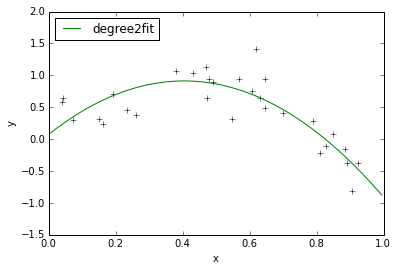

In [14]:
plot_ploy_predictions(data,model)

## Fit a degree-4 polynomial

learned polynomial for degree4:
       4         3         2
23.87 x - 53.82 x + 35.23 x - 6.828 x + 0.7755


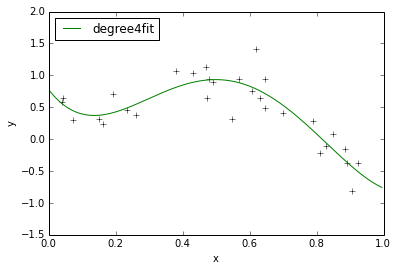

In [15]:
model = polynomial_regression(data, deg=4)
print_coefficients(model)
plot_ploy_predictions(data,model)

## Fit a degree-16 polynomial

In [16]:
model = polynomial_regression(data, deg=16)
print_coefficients(model)

learned polynomial for degree16:
           16             15             14             13
5.327e+05 x  - 4.611e+06 x  + 1.411e+07 x  - 1.982e+07 x 
              12             11             10             9
 + 1.092e+07 x  + 3.755e+06 x  - 8.639e+06 x  + 5.854e+06 x
              8             7             6           5             4
 - 4.552e+06 x + 4.713e+06 x - 3.422e+06 x + 1.5e+06 x - 3.954e+05 x
              3        2
 + 6.139e+04 x - 5241 x + 211.4 x - 2.51


### Woah!!!!  Those coefficients are *crazy*!  On the order of 10^6.

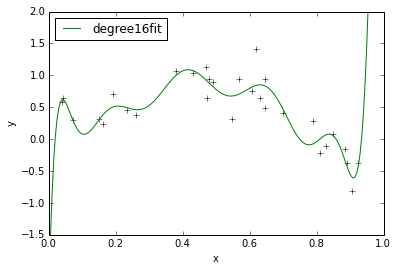

In [17]:
plot_ploy_predictions(data,model)

### Above: Fit looks pretty wild, too.  Here's a clear example of how overfitting is associated with very large magnitude estimated coefficients.

## Ridge Regression¶

Ridge regression aims to avoid overfitting by adding a cost to the RSS term of standard least squares that depends on the 2-norm of the coefficient ||w||. The result is penalizing fits with large coefficients. The strength of this penalty, and thus the fit vs. model complexity balance, is controled by a parameter lambda(here I named it "L2_penalty")

In [18]:
def polynomial_ridge_regression(data,deg,l2_penalty):
    model = graphlab.linear_regression.create(polynomial_features(data,deg),
                                            target='Y', l2_penalty = l2_penalty,
                                            validation_set = None, verbose = False)
    return model

In [19]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=100)
print_coefficients(model)

learned polynomial for degree16:
        16          15          14          13          12         11
-0.301 x  - 0.2802 x  - 0.2604 x  - 0.2413 x  - 0.2229 x  - 0.205 x 
           10          9          8          7          6           5
 - 0.1874 x  - 0.1699 x - 0.1524 x - 0.1344 x - 0.1156 x - 0.09534 x
            4           3           2
 - 0.07304 x - 0.04842 x - 0.02284 x - 0.002257 x + 0.6416


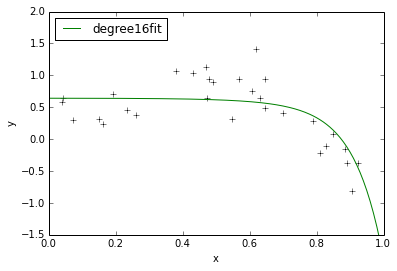

In [20]:
plot_ploy_predictions(data,model)

## Let's look at fits for a sequence of increasing lambda values

lambda = 1.00e-25
learned polynomial for degree16:
           16             15             14             13
5.327e+05 x  - 4.611e+06 x  + 1.411e+07 x  - 1.982e+07 x 
              12             11             10             9
 + 1.092e+07 x  + 3.755e+06 x  - 8.639e+06 x  + 5.854e+06 x
              8             7             6           5             4
 - 4.552e+06 x + 4.713e+06 x - 3.422e+06 x + 1.5e+06 x - 3.954e+05 x
              3        2
 + 6.139e+04 x - 5241 x + 211.4 x - 2.51


lambda = 1.00e-10
learned polynomial for degree16:
           16            15             14             13
4.974e+04 x  - 7.82e+04 x  - 2.266e+04 x  + 3.949e+04 x 
              12        11             10             9             8
 + 4.365e+04 x  + 3079 x  - 3.332e+04 x  - 2.786e+04 x + 1.033e+04 x
              7        6             5             4        3         2
 + 2.962e+04 x - 1439 x - 2.597e+04 x + 1.839e+04 x - 5596 x + 866.2 x - 65.19 x + 2.159


lambda = 1.00e-06
learned polynomial

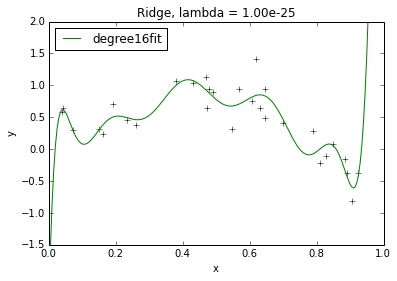

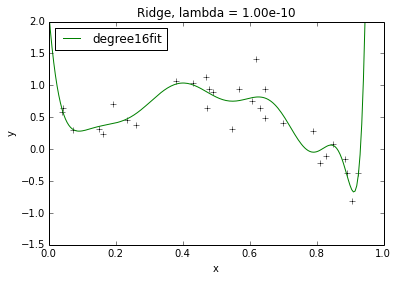

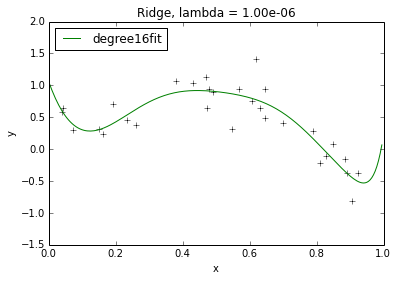

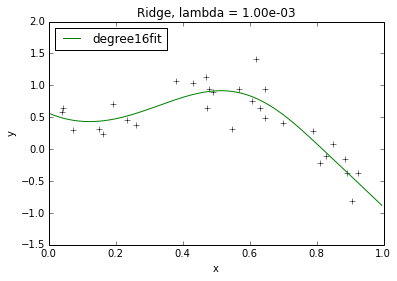

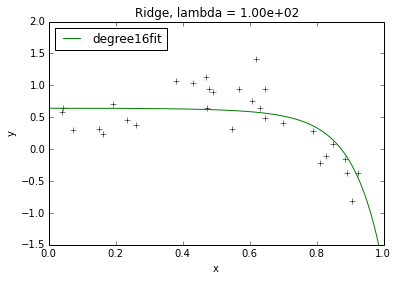

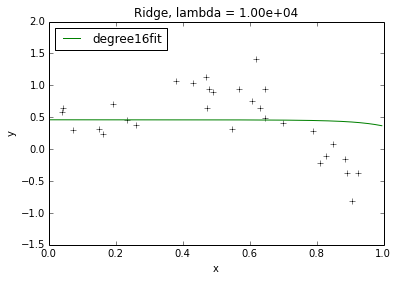

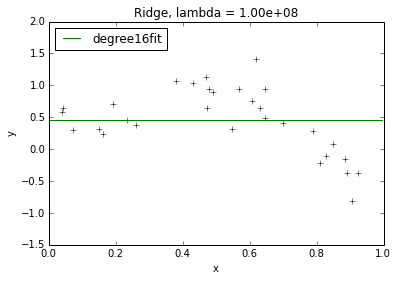

In [21]:
for l2_penalty in [1e-25,1e-10,1e-6,1e-3,1e2,1e4,1e8]:
    model = polynomial_ridge_regression(data, deg=16, l2_penalty=l2_penalty)
    print 'lambda = %.2e' % l2_penalty
    print_coefficients(model)
    print '\n'
    plt.figure()
    plot_ploy_predictions(data,model)
    plt.title('Ridge, lambda = %.2e' % l2_penalty)

## Perform a ridge fit of a degree-16 polynomial using a "good" penalty strength

we will learn about cross validation later in this course as a way to select good valueof the tuning parameter (penalty strength) lambda. Here, we consider "leave one out"(LOO) cross validation, showing approximately average mean square error(MSE). As a result, chosing lambda to minimize the LOO error is equivalent to choosing lambda to minimize an approximation to average MSE.

In [22]:
# LOO cross validation -- return the average MSE
def loo(data, deg, l2_penalty_values):
    # create polynomial features
    polynomial_features(data,deg)
    # create as many folds for cross validation as number of data points
    num_folds = len(data)
    folds = graphlab.cross_validation.KFold(data,num_folds)
    
    
    # for each as many folds for cross validation as number of data points
    l2_penalty_mse =[]
    min_mse = None
    best_l2_penalty = None
    for l2_penalty in l2_penalty_values:
        next_mse =0.0
        for train_set, validation_set in folds:
            # train model
            model = graphlab.linear_regression.create(train_set, target='Y',
                                                     l2_penalty = l2_penalty,
                                                     validation_set=None,verbose=False )
            # prediction on validation set
            y_test_predicted = model.predict(validation_set)
            # compute squared error
            next_mse += ((y_test_predicted - validation_set['Y'])**2).sum()
            
        # save squared error in list of MSE for each l2_penalty
        next_mse = next_mse / num_folds
        l2_penalty_mse.append(next_mse)
        if min_mse is None or next_mse < min_mse:
            min_mse = next_mse
            best_l2_penalty = l2_penalty 
            
    return l2_penalty_mse, best_l2_penalty

Run LOO cross validation for 'num' values of lambda, on a log scale

In [23]:
l2_penalty_values = numpy.logspace(-4,10,num=10)
# look the graph below and I will understand what above sentences mean
l2_penalty_mse, best_l2_penalty = loo(data, 16,l2_penalty_values)

Plot results estimating LOO for each value of lambda

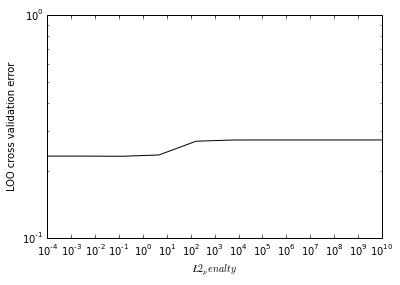

In [24]:
plt.plot(l2_penalty_values, l2_penalty_mse,'k-')
plt.xlabel('$\L2_penalty$')
plt.ylabel('LOO cross validation error')
plt.xscale('log')
plt.yscale('log')

Find the value if lambda,  $\lambda_{\mathrm{CV}}$, that minimizes the LOO cross validation error, and plot resuting fit

In [25]:
best_l2_penalty

0.12915496650148839

In [27]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty = best_l2_penalty)
print_coefficients(model)

learned polynomial for degree16:
       16         15          14          13          12           11
1.345 x  + 1.141 x  + 0.9069 x  + 0.6447 x  + 0.3569 x  + 0.04947 x 
           10          9          8         7         6         5
 - 0.2683 x  - 0.5821 x - 0.8701 x - 1.099 x - 1.216 x - 1.145 x
           4           3          2
 - 0.7837 x - 0.07406 x + 0.7614 x + 0.7703 x + 0.3918


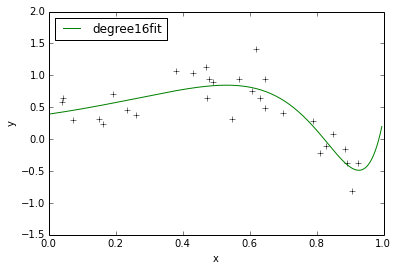

In [28]:
plot_ploy_predictions(data,model)

# Lasso Regression

Lasso regression jointly shirinks coefficiently to avoid overfitting,
and implicity performs features selection by setting some coefficients exactly to 0 for sufficiently large penalty strength lambda(here called "L1_penalty").
In particular, lasso takes the RSS term of standard least squares and adds a 1-norm cost of the coefficients $\|w\|$.

In [41]:
def polynomial_lasso_regression(data, deg, l1_penalty):
    model = graphlab.linear_regression.create(polynomial_features(data,deg),
                                             target = 'Y', l2_penalty=0.,
                                             l1_penalty =l1_penalty,
                                             validation_set=None,
                                             solver='fista',verbose=False,
                                             max_iterations=3000, convergence_threshold=1e-10)
    return model

## Explore the lasso solution as a function of a few different penalty strengths

l1_penalty = 1.000000e-04
number of nonzeros = 17
learned polynomial for degree16:
       16        15         14         13         12         11
29.02 x  + 1.35 x  - 12.72 x  - 16.93 x  - 13.82 x  - 6.698 x 
          10         9         8         7         6         5
 + 1.407 x  + 8.939 x + 12.88 x + 11.44 x + 3.759 x - 8.062 x
          4         3         2
 - 16.28 x - 7.682 x + 17.86 x - 4.384 x + 0.685


l1_penalty = 1.000000e-02
number of nonzeros = 14
learned polynomial for degree16:
        16             15          11          10         9          8
-1.181 x  - 0.0004539 x  + 0.0867 x  + 0.7382 x  + 3.828 x + 0.4756 x
           7            6          5         4             3         2
 + 0.1279 x + 0.003731 x - 0.6154 x - 10.11 x + 0.0004891 x + 6.686 x - 1.28 x + 0.5055


l1_penalty = 1.000000e-01
number of nonzeros = 5
learned polynomial for degree16:
      16         6         5
2.21 x  - 1.002 x - 2.962 x + 1.216 x + 0.3473


l1_penalty = 1.000000e+01
number of n

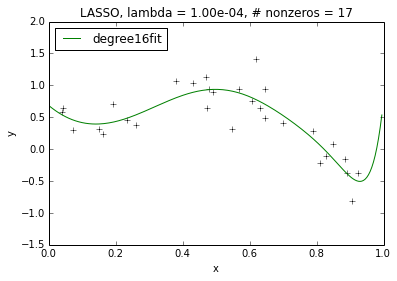

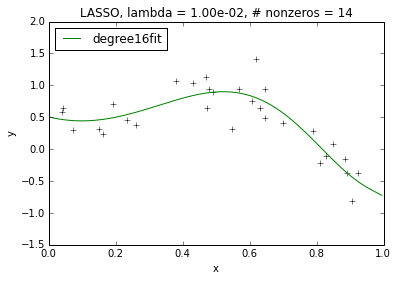

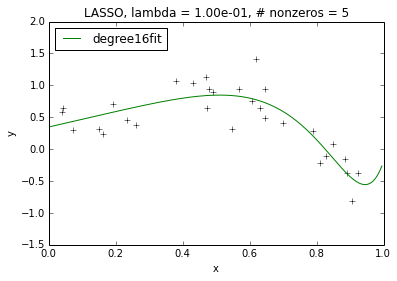

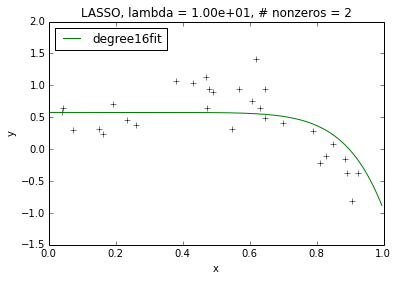

In [45]:
for l1_penalty in [0.0001,0.01,0.1,10]:
    model = polynomial_lasso_regression(data, deg=16, l1_penalty=l1_penalty)

    print 'l1_penalty = %e' % l1_penalty
    
    print 'number of nonzeros = %d' % (model.coefficients['value']).nnz()
    
    # number of nonzero values; explicit zero values are included in this number
    print_coefficients(model)
    print '\n'
    plt.figure()
    plot_ploy_predictions(data,model)
    plt.title('LASSO, lambda = %.2e, # nonzeros = %d' % (l1_penalty, (model.coefficients['value']).nnz()))
   

Above: We see that as lambda increases, we get sparser and sparser solutions.  However, even for our non-sparse case for lambda=0.0001, the fit of our high-order polynomial is not too wild.  This is because, like in ridge, coefficients included in the lasso solution are shrunk relative to those of the least squares (unregularized) solution.  This leads to better behavior even without sparsity.  Of course, as lambda goes to 0, the amount of this shrinkage decreases and the lasso solution approaches the (wild) least squares solution.